In [1]:
## Essential Python Libraries
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
import scrublet as scr
import bbknn
import ma_codes as codes
from ma_codes import mysize, gray_red, mymap

sc.settings.verbosity = 3               # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_version_and_date()

Running Scanpy 1.8.1, on 2021-09-21 12:03.


In [2]:
## Set File Paths and some Plotting parameters
out_folder = "/home/marvin/Data/platte_2/210921_Aging_Tutorial/"
dge_path = "/mnt/smb/count_matrices/210921_Aging_Tutorial/"

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams.update({'font.size': 14})
plt.rcParams['pdf.fonttype'] = 42

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore")
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

In [3]:
%%R
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(SoupX))
suppressPackageStartupMessages(library(SingleCellExperiment))
suppressPackageStartupMessages(library(Matrix))

### Read in Grouping File

In [4]:
from os import listdir

files = sorted([f for f in sorted(listdir(dge_path)) if ".dge.txt" in f])
samples = [f.replace(".dge.txt.gz", "") for f in files]
files

['muc3838.dge.txt.gz',
 'muc3839.dge.txt.gz',
 'muc3840.dge.txt.gz',
 'muc3841.dge.txt.gz',
 'muc4166.dge.txt.gz',
 'muc4167.dge.txt.gz',
 'muc4168.dge.txt.gz',
 'muc4169.dge.txt.gz',
 'muc4170.dge.txt.gz',
 'muc4172.dge.txt.gz',
 'muc4173.dge.txt.gz',
 'muc4174.dge.txt.gz',
 'muc4175.dge.txt.gz']

In [5]:
grouping = pd.read_csv(out_folder + "aged_mice_samples.txt", sep = '\t', header = (0), index_col = 0)
grouping

name  batch  age  cells   data_set
identifier                                                        
muc3838           Aging mouse 1 Male  pilot  24m    800  aged_mice
muc3839           Aging mouse 2 Male  pilot  24m    500  aged_mice
muc3840        Aging PBS-Ctrl day 14  pilot   3m    500  aged_mice
muc3841     Ageing PBS Ctrl 2 day 21  pilot   3m    500  aged_mice
muc4166           Aging mouse 3 Male  aging  24m   1000  aged_mice
muc4167           Aging mouse 4 Male  aging   4m   1000  aged_mice
muc4168         Aging mouse 5 Female  aging  24m   1000  aged_mice
muc4169              ctrl PBS day 14  aging   3m   1000  aged_mice
muc4170              ctrl PBS day 21  aging   3m   1000  aged_mice
muc4172            PBS ctrl day 10_1  aging   3m   1000  aged_mice
muc4173             PBSctrl day 10_2  aging   3m   1000  aged_mice
muc4174               Aging 6 Female  aging  24m   1000  aged_mice
muc4175               Aging 7 Female  aging  24m   1000  aged_mice

### Read in Count Matrices

In [6]:
def read_dges(files, samples):
    adatas = []
    for file, sample in zip(files, samples):
        print("Reading DGE for sample %s\t%s" %(sample, codes.timestamp()))
        a = sc.read_text(dge_path + file).T
        
        ## Add all columns from Grouping Table as Metainfo (apart from cells)
        for col in np.setdiff1d(grouping.columns, "cells"):
            a.obs[col] = grouping.loc[sample, col]

        a.obs_names = ["%s_%s" %(sample, cell) for cell in a.obs_names.values]
        adatas.append(a)
    return adatas

In [7]:
## Load dges and concatenate them into one adata file (assign categories automatically)
adatas = read_dges(files, samples)
adata = adatas[0].concatenate(adatas[1:], batch_key = "identifier", join = "outer", index_unique = None)  
adata.obs["identifier"].cat.categories = samples

## As outer join is used when concatenating the adatas, set NaN entries to zero
adata.X = np.nan_to_num(adata.X)
adata

Reading DGE for sample muc3838	21-09-2021 12:05:24
Reading DGE for sample muc3839	21-09-2021 12:05:25
Reading DGE for sample muc3840	21-09-2021 12:05:26
Reading DGE for sample muc3841	21-09-2021 12:05:27
Reading DGE for sample muc4166	21-09-2021 12:05:28
Reading DGE for sample muc4167	21-09-2021 12:05:34
Reading DGE for sample muc4168	21-09-2021 12:05:35
Reading DGE for sample muc4169	21-09-2021 12:05:38
Reading DGE for sample muc4170	21-09-2021 12:05:42
Reading DGE for sample muc4172	21-09-2021 12:05:47
Reading DGE for sample muc4173	21-09-2021 12:05:50
Reading DGE for sample muc4174	21-09-2021 12:05:54
Reading DGE for sample muc4175	21-09-2021 12:05:56


AnnData object with n_obs × n_vars = 23946 × 21826
    obs: 'age', 'batch', 'data_set', 'name', 'identifier'

In [8]:
adata.obs["identifier"].value_counts()

muc4166    3783
muc4170    3555
muc4175    3108
muc4169    2725
muc4173    2611
muc4168    1695
muc4174    1616
muc4172    1505
muc4167    1048
muc3838     800
muc3839     500
muc3840     500
muc3841     500
Name: identifier, dtype: int64

### Generate Synthetic Bulk

In [9]:
group = "identifier"       ## will be the columns of the bulk table
bulk = pd.DataFrame(data = adata.var_names.values, columns = ["Genes"])

for i in adata.obs.loc[:, group].cat.categories:
    temp = adata.obs.loc[:, group] == i
    bulk[i] = adata[temp].X.sum(0, dtype = int)      # column sums (genes)

## Save to File
bulk.to_csv(out_folder + "210921_aged_mice_SyntheticBulk.txt", sep = "\t", index = False)

In [10]:
bulk.head(2)

Genes  muc3838  muc3839  muc3840  muc3841  muc4166  muc4167  \
0  0610005C13Rik        1        1        1        0        2        0   
1  0610007N19Rik        4       10       24       10       67        9   

   muc4168  muc4169  muc4170  muc4172  muc4173  muc4174  muc4175  
0        0        2        1        0        0        2        1  
1       16       74       62       52      112       19       31

### Preprocessing and Quality Control
Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

In [11]:
## Human
# mt_genes = [gene.startswith("MT-") for gene in adata.var_names]
# print(sum(mt_genes))

## Mouce
mt_genes = [gene.startswith("mt-") for gene in adata.var_names]
print(sum(mt_genes))

31


In [12]:
# Quality control - calculate QC Metrics
adata.obs["n_counts"] = adata.X.sum(1)         # sums over rows = cells
adata.obs["n_genes"] = (adata.X > 0).sum(1)
adata.obs["percent_mito"] = adata.X[:, mt_genes].sum(1) / adata.obs["n_counts"]

In [13]:
## Summary Statistics before Filtering
group = "name"
info = pd.DataFrame(data = adata.obs.identifier.cat.categories, columns = ["identifier"])
info[group] = grouping.loc[info.identifier.values].loc[:, group].values
info["n_counts"] = adata.obs.groupby(["identifier"])["n_counts"].median().values
info["n_genes"] = adata.obs.groupby(["identifier"])["n_genes"].median().values
info["percent_mito"] = adata.obs.groupby(["identifier"])["percent_mito"].mean().values
info["n_cells"] = adata.obs.groupby(["identifier"])["n_genes"].size().values
info.to_csv(out_folder + "210921_aged_mice_info.txt", sep = "\t", na_rep = "NA", index = False)
info

identifier                      name  n_counts  n_genes  percent_mito  \
0     muc3838        Aging mouse 1 Male     682.0    361.0      0.023740   
1     muc3839        Aging mouse 2 Male     699.5    469.5      0.024843   
2     muc3840     Aging PBS-Ctrl day 14    1233.0    659.0      0.023072   
3     muc3841  Ageing PBS Ctrl 2 day 21     720.0    408.0      0.020523   
4     muc4166        Aging mouse 3 Male     448.0    313.0      0.042849   
5     muc4167        Aging mouse 4 Male     409.5    280.0      0.040817   
6     muc4168      Aging mouse 5 Female     631.0    424.0      0.011678   
7     muc4169           ctrl PBS day 14     658.0    400.0      0.026260   
8     muc4170           ctrl PBS day 21     525.0    306.0      0.020239   
9     muc4172         PBS ctrl day 10_1     593.0    359.0      0.026913   
10    muc4173          PBSctrl day 10_2     690.0    388.0      0.025044   
11    muc4174            Aging 6 Female     538.5    371.5      0.013309   
12    muc4175            Aging 7 Female     429.0    295.0      0.015719   

    n_cells  
0       800  
1       500  
2       500  
3       500  
4      3783  
5      1048  
6      1695  
7      2725  
8      3555  
9      1505  
10     2611  
11     1616  
12     3108

### Save this unfiltered, unnormalized, raw count object

In [14]:
from scipy import sparse
adata.X = sparse.csr_matrix(adata.X)
print(type(adata.X))
adata

<class 'scipy.sparse.csr.csr_matrix'>


AnnData object with n_obs × n_vars = 23946 × 21826
    obs: 'age', 'batch', 'data_set', 'name', 'identifier', 'n_counts', 'n_genes', 'percent_mito'

In [15]:
object_folder = "/home/marvin/Data/platte_2/210921_Aging_Tutorial/"
adata.write(object_folder + "210921_Aged_Mice_rawcounts.h5ad")             ## 85 MB

### Quality control - plot QC Metrics

... storing 'age' as categorical
... storing 'batch' as categorical
... storing 'data_set' as categorical
... storing 'name' as categorical


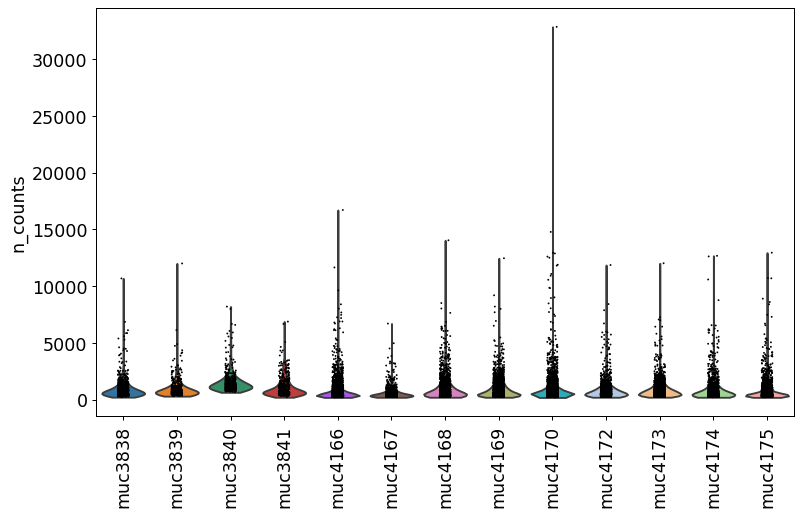

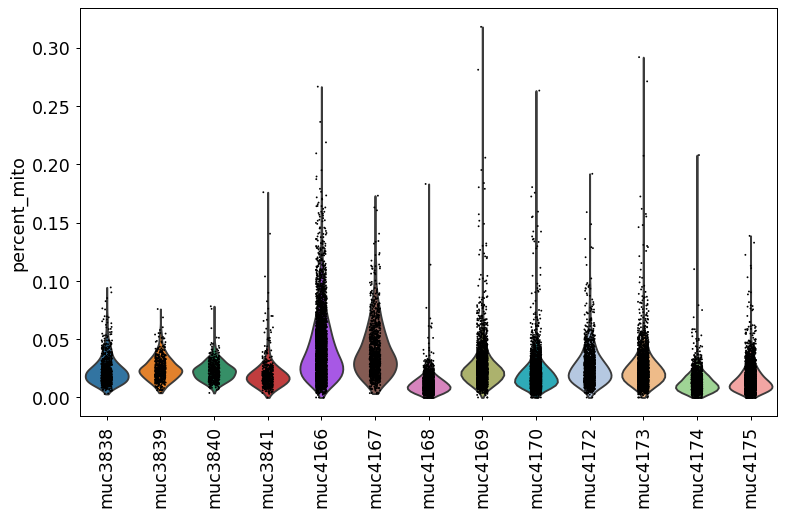

In [16]:
group = "identifier"
sc.pl.violin(adata, "n_counts", groupby = group, size = 1.5, ax = mysize(10, 6, 90), rotation = 90)
sc.pl.violin(adata, "percent_mito", groupby = group, size = 1.5, ax = mysize(10, 6, 90), rotation = 90)

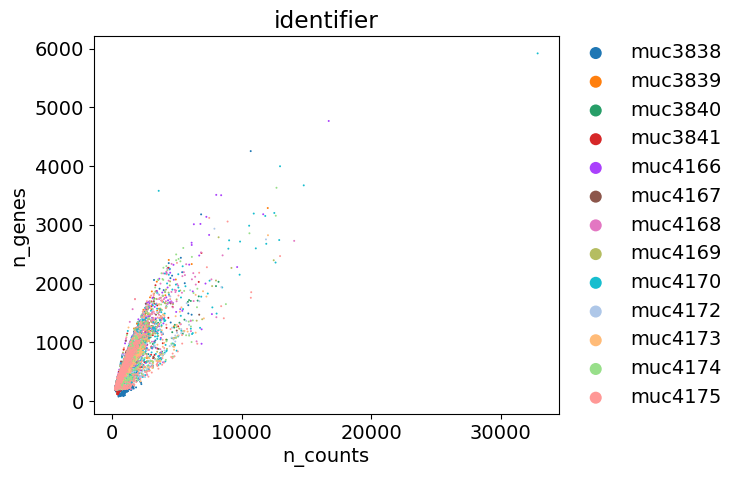

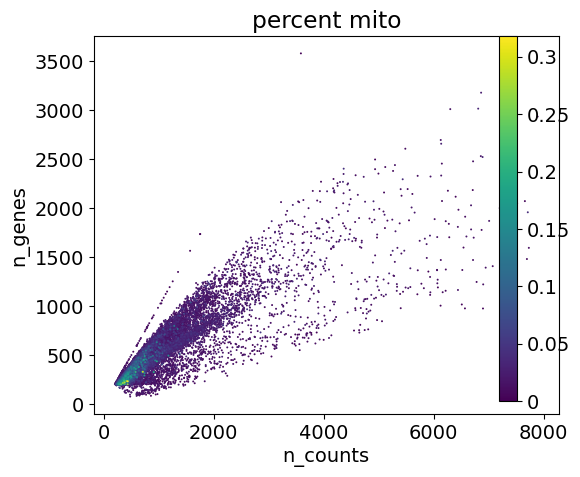

In [17]:
#Data quality summary plots
group = "identifier"
sc.pl.scatter(adata, "n_counts", "n_genes", color = group, ax = mysize(6, 5, 100), size = 8)

## Zoom in to range
sc.pl.scatter(adata[adata.obs["n_counts"] < 8000],"n_counts","n_genes", ax = mysize(6, 5, 100),
              color = "percent_mito", size = 8)

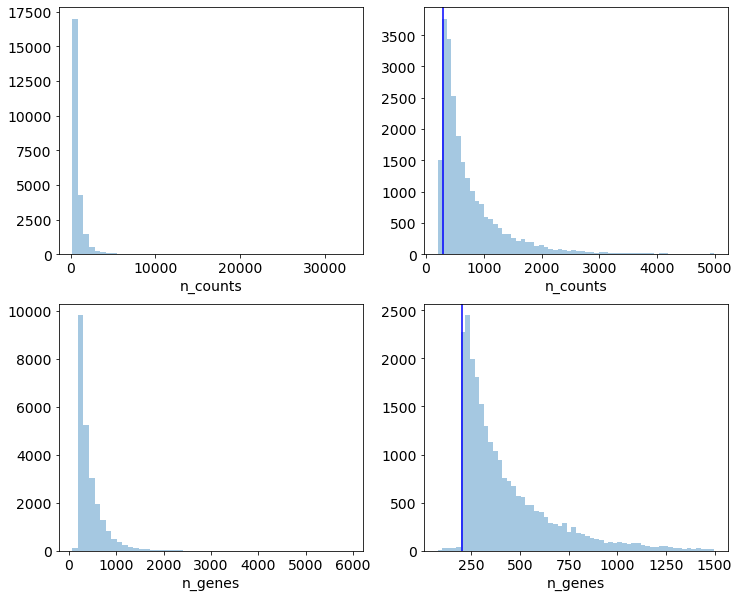

In [18]:
#Thresholding decision: counts (by default lower cut at 200 when reading in dges)
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))
axs = axs.ravel()

sb.distplot(adata.obs['n_counts'], kde = False, ax = axs[0])
sb.distplot(adata.obs['n_counts'][adata.obs['n_counts'] < 5000], kde = False, bins = 60, ax = axs[1])
sb.distplot(adata.obs['n_genes'], kde = False, ax = axs[2])
sb.distplot(adata.obs['n_genes'][adata.obs['n_genes'] < 1500], kde = False, bins = 60, ax = axs[3])

axs[1].axvline(300, color = "blue")
axs[3].axvline(200, color = "blue")
plt.show()

### Sample specific thresholds

In [19]:
## Get a list of all identifier
adata.obs.identifier.cat.categories

Index(['muc3838', 'muc3839', 'muc3840', 'muc3841', 'muc4166', 'muc4167',
       'muc4168', 'muc4169', 'muc4170', 'muc4172', 'muc4173', 'muc4174',
       'muc4175'],
      dtype='object')

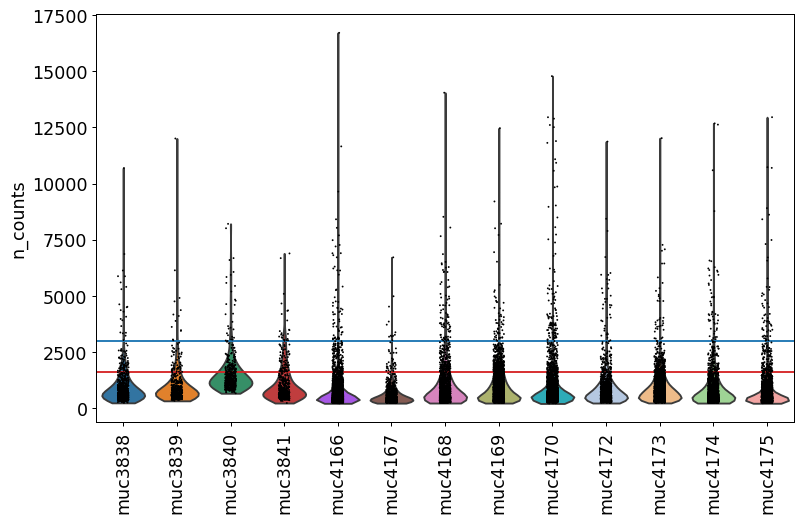

In [20]:
sc.pl.violin(adata[adata.obs.n_counts < 20000], "n_counts", groupby = group, 
             ax = mysize(10, 6, 90), rotation = 90, size = 1.5, show = False)

## To inspect potential cutoffs
plt.axhline(3000, color = "tab:blue")     ## high
## plt.axhline(3000, color = "yellowgreen")      ## medium
plt.axhline(1600, color = "tab:red")  ## low
plt.show()

In [21]:
groups = {'muc3838': "low", 'muc3839': "low", 'muc3840': "high", 'muc3841': "low", 'muc4166': "high", 
          'muc4167': "low", 'muc4168': "high", 'muc4169': "high", 'muc4170': "high", 'muc4172': "low",
          'muc4173': "high", 'muc4174': "high", 'muc4175': "high"}
adata.obs["QC_group"] = [groups[c] if c in groups.keys() else "high" for c in adata.obs.identifier]

sc._utils.sanitize_anndata(adata)
adata.obs.QC_group.value_counts()

... storing 'QC_group' as categorical


high    19593
low      4353
Name: QC_group, dtype: int64

23040


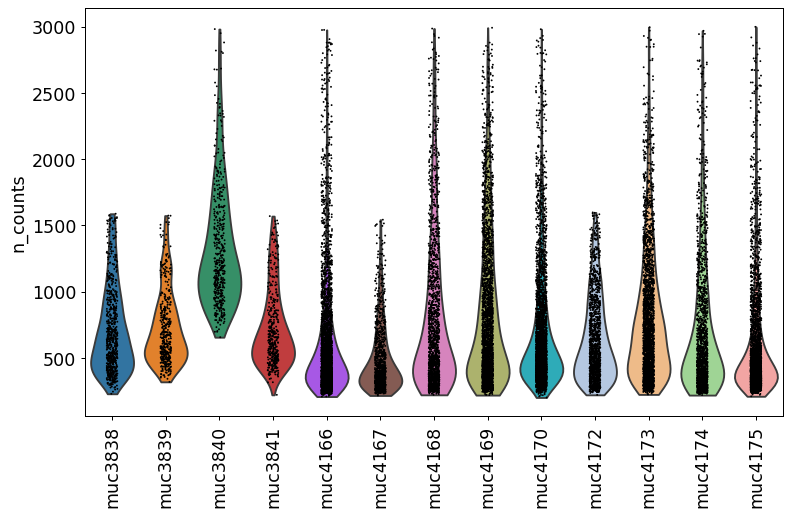

In [22]:
## Specify group-specific thresholds and do the filtering
thresh = {"low": 1600, "high": 3000}

passed_cells = [c for c, g in zip(adata.obs_names, adata.obs.QC_group) if adata.obs.n_counts[c] < thresh[g]]
print(len(passed_cells))
adata._inplace_subset_obs(passed_cells)
sc.pl.violin(adata, "n_counts", groupby = group, size = 1.5, ax = mysize(10, 6, 90), rotation = 90)

### Actually do the Filtering for remaining QC Parameters

In [23]:
print('Total number of cells: {:d}'.format(adata.n_obs))

## Do not need this if sample-wise thresholds above were done
#sc.pp.filter_cells(adata, max_counts = 50000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 300)
sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_genes(adata, min_cells = 3)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs["percent_mito"] < 0.1]            
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

Total number of cells: 23040
filtered out 2402 cells that have less than 300 counts
filtered out 144 cells that have less than 200 genes expressed
Number of cells after min count filter: 20494
filtered out 3807 genes that are detected in less than 3 cells
Number of cells after gene filter: 20494
Number of cells after MT filter: 20249


### Plots after Filtering

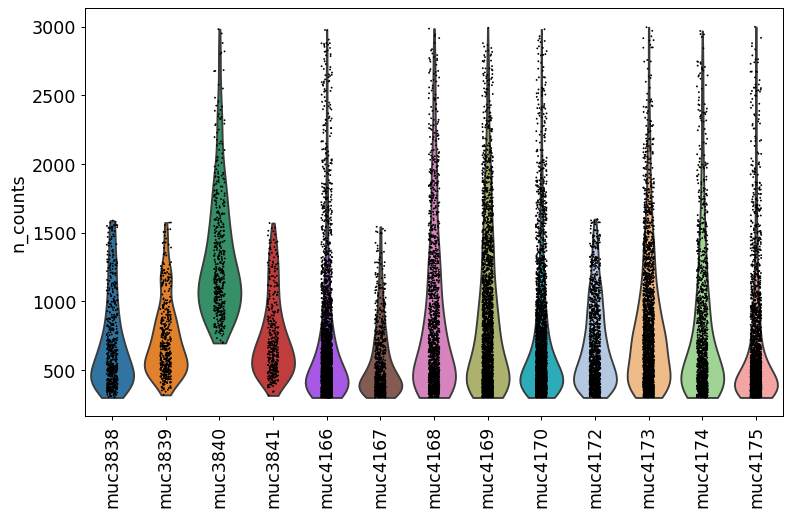

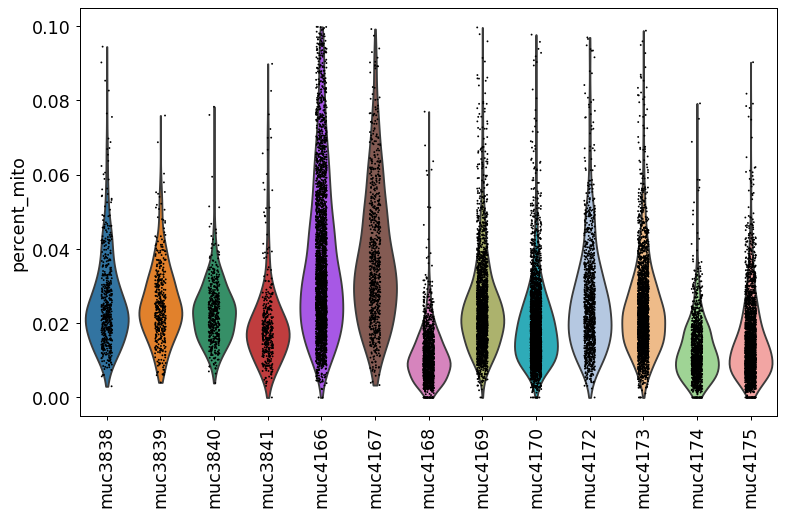

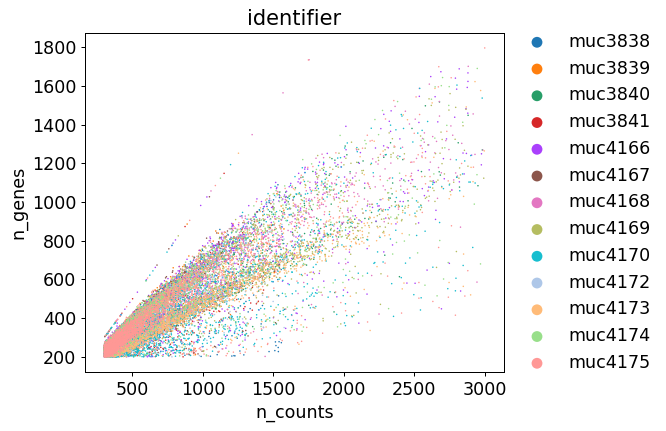

In [24]:
sc.pl.violin(adata, "n_counts", groupby = group, size = 1.5, ax = mysize(10, 6, 90), rotation = 90)
sc.pl.violin(adata, "percent_mito", groupby = group, size = 1.5, ax = mysize(10, 6, 90), rotation = 90)
sc.pl.scatter(adata, "n_counts", "n_genes", color = group, ax = mysize(6, 5, 90))

In [25]:
## Summary Statistics after Filtering
group = "name"
info = pd.DataFrame(data = adata.obs.identifier.cat.categories, columns = ["identifier"])
info[group] = grouping.loc[info.identifier.values].loc[:, group].values
info["n_counts"] = adata.obs.groupby(["identifier"])["n_counts"].median().values
info["n_genes"] = adata.obs.groupby(["identifier"])["n_genes"].median().values
info["percent_mito"] = adata.obs.groupby(["identifier"])["percent_mito"].mean().values
info["n_cells"] = adata.obs.groupby(["identifier"])["n_genes"].size().values
info.to_csv(out_folder + "210921_aged_mice_info_filtered.txt", sep = "\t", na_rep = "NA", index = False)
info

identifier                      name  n_counts  n_genes  percent_mito  \
0     muc3838        Aging mouse 1 Male     593.5    375.5      0.025988   
1     muc3839        Aging mouse 2 Male     665.0    441.0      0.025434   
2     muc3840     Aging PBS-Ctrl day 14    1209.0    642.0      0.023285   
3     muc3841  Ageing PBS Ctrl 2 day 21     656.5    371.5      0.020083   
4     muc4166        Aging mouse 3 Male     508.0    348.0      0.037750   
5     muc4167        Aging mouse 4 Male     466.0    308.0      0.037639   
6     muc4168      Aging mouse 5 Female     670.5    450.5      0.011477   
7     muc4169           ctrl PBS day 14     716.0    422.0      0.024758   
8     muc4170           ctrl PBS day 21     529.0    310.0      0.019698   
9     muc4172         PBS ctrl day 10_1     596.0    362.0      0.026397   
10    muc4173          PBSctrl day 10_2     715.0    401.0      0.024154   
11    muc4174            Aging 6 Female     588.0    402.0      0.012992   
12    muc4175            Aging 7 Female     463.0    317.0      0.015363   

    n_cells  
0       578  
1       433  
2       470  
3       376  
4      2961  
5       761  
6      1424  
7      2407  
8      3254  
9      1229  
10     2393  
11     1344  
12     2619

### Doublet Detection with Scrublet (sample-wise)

In [26]:
ids = adata.obs.identifier.cat.categories
adata.obs["doublet_scores"] = np.nan

for i, cur_id in enumerate(ids):
    sub = adata[adata.obs.identifier == cur_id].copy()

    ## Input: raw (unnormalized) UMI counts matrix counts_matrix with cells as rows and genes as columns
    print("%s\tCalculating doublet score for %s\t%s" %(i, cur_id, codes.timestamp()))
    scrub = scr.Scrublet(sub.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose = False)
    doublet_scores = pd.DataFrame(doublet_scores, index = sub.obs_names, columns = ["doublet_scores"])
    adata.obs["doublet_scores"].update(doublet_scores.doublet_scores)
    

Trying to set attribute `.obs` of view, copying.


0	Calculating doublet score for muc3838	21-09-2021 12:08:47
1	Calculating doublet score for muc3839	21-09-2021 12:08:47
2	Calculating doublet score for muc3840	21-09-2021 12:08:47
3	Calculating doublet score for muc3841	21-09-2021 12:08:48
4	Calculating doublet score for muc4166	21-09-2021 12:08:48
5	Calculating doublet score for muc4167	21-09-2021 12:08:49
6	Calculating doublet score for muc4168	21-09-2021 12:08:49
7	Calculating doublet score for muc4169	21-09-2021 12:08:49
8	Calculating doublet score for muc4170	21-09-2021 12:08:50
9	Calculating doublet score for muc4172	21-09-2021 12:08:51
10	Calculating doublet score for muc4173	21-09-2021 12:08:51
11	Calculating doublet score for muc4174	21-09-2021 12:08:52
12	Calculating doublet score for muc4175	21-09-2021 12:08:52


In [27]:
## Intermediate Save at this point
object_folder = "/home/marvin/Data/platte_2/210921_Aging_Tutorial/"
adata.write(object_folder + "210921_Aged_Mice.h5ad")             ## 71 MB

### Ambient gene removal with SoupX and normalization with Scran

In [28]:
%%R
## Define the Functions beforehand

soup_counts <- function(data, cells, genes, soupx_groups){
    print(dim(data))
    rownames(data) = genes
    colnames(data) = cells
    data <- as(data, "sparseMatrix")
    
    ## Generate SoupChannel Object for SoupX - no option to visualize though
    sc = SoupChannel(data, data, calcSoupProfile = FALSE)
    soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
    sc = setSoupProfile(sc, soupProf)
    sc = setClusters(sc, soupx_groups)

    ## Set the Contamination Fraction manually (0.3 seemed to work best for my testruns)
    print(paste("Started SoupX", Sys.time()))
    sc = setContaminationFraction(sc, 0.3)
    out = adjustCounts(sc, roundToInt = TRUE)
    print(paste("Finished SoupX", Sys.time()))
    return(out)
}

get_size_factors <- function(out, scran_groups){
    ## Input souped count matrix directly to Scran
    print(paste("Started Size Factor Calculation", Sys.time()))
    size_factors = computeSumFactors(out, clusters = scran_groups, min.mean = 0.1)
    print(paste("Finished Size Factor Calculation", Sys.time()))
    
    return(size_factors)
}

In [32]:
#Perform a clustering for SoupX and scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after = 1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps = 15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added = "soupx_groups", resolution = 2)
sc.tl.louvain(adata_pp, key_added = "scran_groups", resolution = 1)

#Preprocess variables for SoupX and scran normalization
soupx_groups = adata_pp.obs["soupx_groups"]
scran_groups = adata_pp.obs["scran_groups"] 

cells = adata.obs_names
genes = adata.var_names
data = adata.X.T.todense()

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 28 clusters and added
    'soupx_groups', the cluster labels (adata.obs, categorical) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'scran_groups', the cluster labels (adata.obs, categorical) (0:00:01)


In [33]:
data.shape

(18019, 20249)

In [34]:
%R -i data -i cells -i genes -i soupx_groups out <- soup_counts(data, cells, genes, soupx_groups)
%R -o data data <- t(as.matrix(out))
%R out <- SingleCellExperiment(list(counts = out))
%R -i scran_groups -o size_factors size_factors <- get_size_factors(out, scran_groups)
%R -o size_factors size_factors <- size_factors@colData@listData$sizeFactor

[1] 18019 20249
[1] "Started SoupX 2021-09-21 12:16:46"


R[write to console]: Expanding counts from 28 clusters to 20249 cells.



[1] "Finished SoupX 2021-09-21 12:16:59"
[1] "Started Size Factor Calculation 2021-09-21 12:17:05"
[1] "Finished Size Factor Calculation 2021-09-21 12:18:32"


array([1.33091282, 2.99307138, 2.87452646, ..., 0.53919047, 0.62677909,
       0.6985924 ])

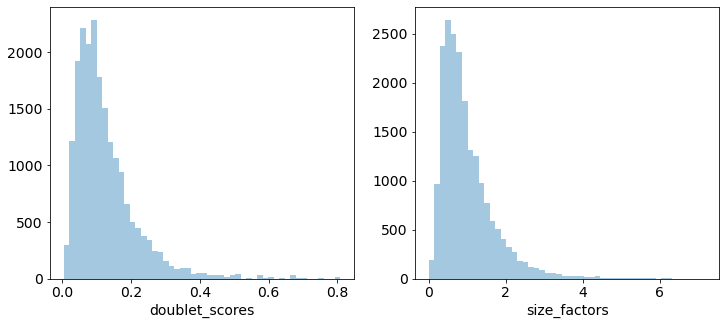

In [35]:
## Add results to adata
adata.obs["size_factors"] = np.nan
size_factors = pd.DataFrame(size_factors, index = adata.obs_names, columns = ["size_factors"])
adata.obs["size_factors"].update(size_factors.size_factors)

## Add souped count layer
from scipy import sparse
adata.layers["unsouped_counts"] = adata.X.copy()
adata.layers["counts"] = sparse.csr_matrix(data.copy())
adata.X = sparse.csr_matrix(data.copy())

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axs = axs.ravel()
sb.distplot(adata.obs["doublet_scores"], kde = False, ax = axs[0])
sb.distplot(adata.obs["size_factors"], kde = False, ax = axs[1])
plt.show()

In [36]:
adata.obs.head()

age  batch   data_set                name identifier  \
muc3838_GTGGGTATTTTT  24m  pilot  aged_mice  Aging mouse 1 Male    muc3838   
muc3838_GAATTTCCGTAC  24m  pilot  aged_mice  Aging mouse 1 Male    muc3838   
muc3838_GTGTCGCCCTGA  24m  pilot  aged_mice  Aging mouse 1 Male    muc3838   
muc3838_TTAACCTCCTCA  24m  pilot  aged_mice  Aging mouse 1 Male    muc3838   
muc3838_CTTGCGCGGCAC  24m  pilot  aged_mice  Aging mouse 1 Male    muc3838   

                      n_counts  n_genes  percent_mito QC_group  \
muc3838_GTGGGTATTTTT    1341.0      649      0.047726      low   
muc3838_GAATTTCCGTAC    1501.0     1011      0.011992      low   
muc3838_GTGTCGCCCTGA    1532.0     1089      0.018930      low   
muc3838_TTAACCTCCTCA    1588.0     1025      0.020781      low   
muc3838_CTTGCGCGGCAC    1364.0      634      0.017595      low   

                      doublet_scores  size_factors  
muc3838_GTGGGTATTTTT        0.096525      1.330913  
muc3838_GAATTTCCGTAC        0.120000      2.993071  
muc3838_GTGTCGCCCTGA        0.058140      2.874526  
muc3838_TTAACCTCCTCA        0.086957      3.614416  
muc3838_CTTGCGCGGCAC        0.064220      1.143536

In [37]:
del(adata_pp)
del(data)

In [38]:
## Normalize adata and Log Transform
adata.X /= adata.obs['size_factors'].values[:, None]
sc.pp.log1p(adata)
adata.X = sparse.csr_matrix(adata.X)

## Do not Store the full data set in 'raw' as log-normalised data for statistical testing 
## As I won’t be changing the .X layer, so .X is essentially adata.raw.X

In [39]:
# print("log-normed counts\n", type(adata.raw.X), "\n", adata.raw.X[10:20,10:15].todense())
print("unsouped counts\n", type(adata.layers["unsouped_counts"]), "\n", 
      adata.layers["unsouped_counts"][0:5, 100:115].todense())
print("souped counts\n", type(adata.layers["counts"]), "\n",  adata.layers["counts"][0:5, 100:115].todense())
print("Counts in X\n", type(adata.X), "\n",  adata.X[0:5, 100:115].todense())

unsouped counts
 <class 'scipy.sparse.csr.csr_matrix'> 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]]
souped counts
 <class 'scipy.sparse.csr.csr_matrix'> 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 2. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]]
Counts in X
 <class 'scipy.sparse.csr.csr_matrix'> 
 [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.5281

In [40]:
## Intermediate Save at this point
object_folder = "/home/marvin/Data/platte_2/210921_Aging_Tutorial/"
adata.write(object_folder + "210921_Aged_Mice.h5ad")             ## 206 MB

### Selection of highly Variable Genes (consider in how many Samples they are variable)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


<AxesSubplot:>

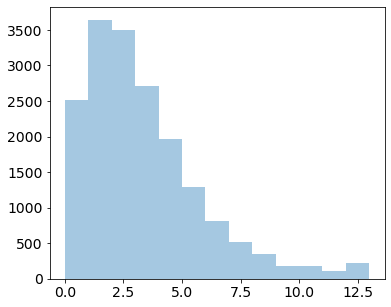

In [41]:
batch = "identifier"
sc.pp.highly_variable_genes(adata, min_disp = None, max_disp = None, min_mean = None, max_mean = None, 
                                batch_key = batch, n_top_genes = 4000, n_bins = 20, flavor = "cell_ranger", 
                                subset = False)
vartab = pd.DataFrame(adata.var["highly_variable_nbatches"], index = adata.var_names)
sb.distplot(vartab, kde = False, bins = len(np.unique(adata.obs[batch])))

In [42]:
thresh = 3
hvgs = vartab[vartab.highly_variable_nbatches.values >= thresh].index
print("%s Genes kept, variable in at least %s samples" %(len(hvgs), thresh))

8371 Genes kept, variable in at least 3 samples


### Remove Cell cycle Genes from list of variable genes

In [43]:
## Score cell cycle and visualize the effect

## Human
# cc_genes = pd.read_table("~/Documents/Meshal/Tutorials/Macosko_cell_cycle_genes_human.txt", delimiter = "\t")

## Mouse
cc_genes = pd.read_table("~/Documents/Meshal/Tutorials/Macosko_cell_cycle_genes_mouse.txt", delimiter = "\t")

s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()
cc_genes = np.concatenate(cc_genes.values)
cc_genes = np.unique([g for g in cc_genes if isinstance(g, str)])

In [44]:
## Remove cell cycle genes from list
hvgs = np.setdiff1d(hvgs, cc_genes)

In [45]:
adata.var["highly_variable"] = [g in hvgs for g in adata.var_names]
sum(adata.var["highly_variable"])

8153

### Calculate cell cycle Score

In [47]:
sc.tl.score_genes_cell_cycle(adata, s_genes = s_genes, g2m_genes = g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    2244 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    2466 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


#### [Skip Regression]

### Visualizations

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


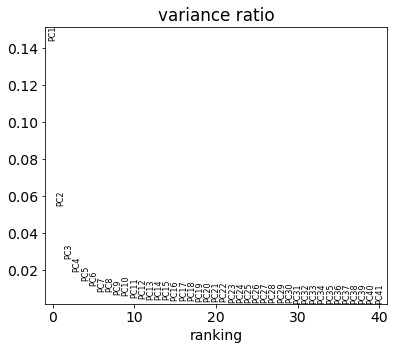

In [48]:
plt.rcParams["figure.figsize"] = (6, 5)
sc.pp.pca(adata, n_comps = 50, use_highly_variable = True)
sc.pl.pca_variance_ratio(adata, n_pcs = 40)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


... storing 'phase' as categorical


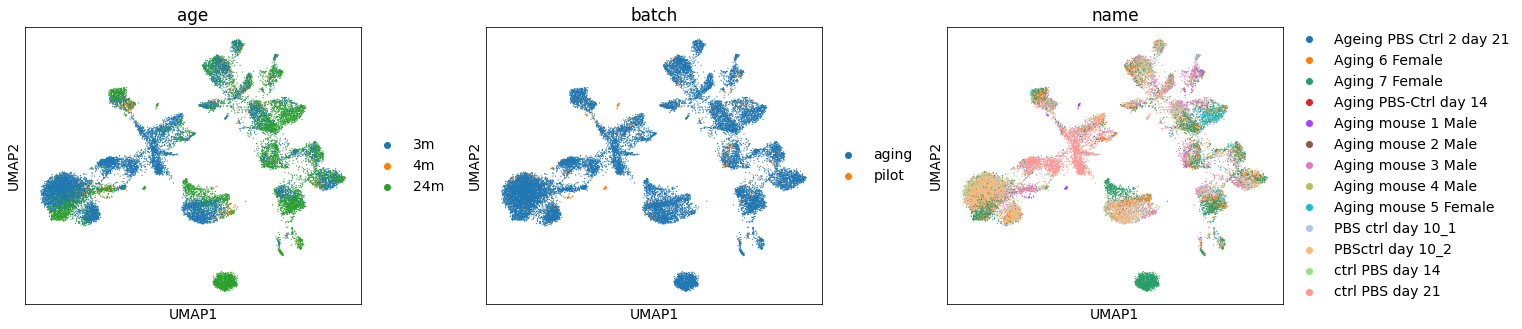

In [49]:
sc.pp.neighbors(adata, n_pcs = 50, n_neighbors = 20)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ["age", "batch", "name"], wspace = 0.25)

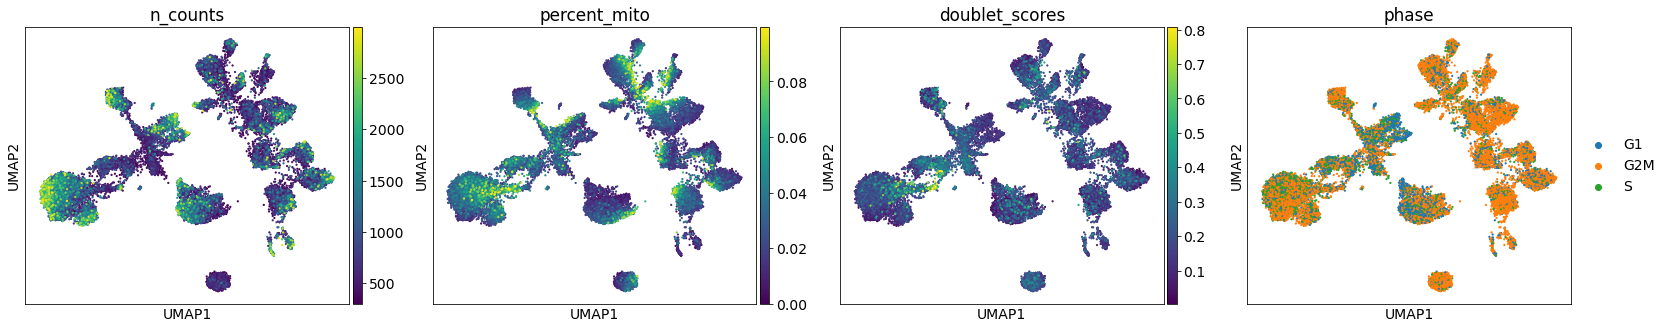

In [50]:
sc.pl.umap(adata, color = ["n_counts", "percent_mito", "doublet_scores", "phase"], size = 20, cmap = "viridis")

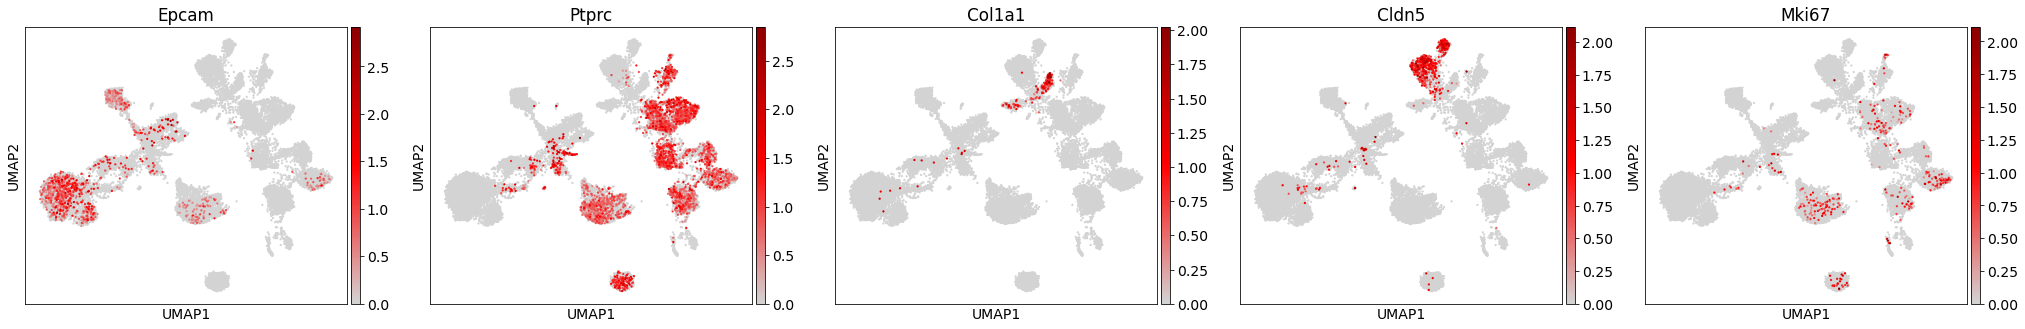

In [51]:
sc.pl.umap(adata, color = ["Epcam", "Ptprc", "Col1a1", "Cldn5", "Mki67"], ncols = 5, cmap = gray_red, size = 20)

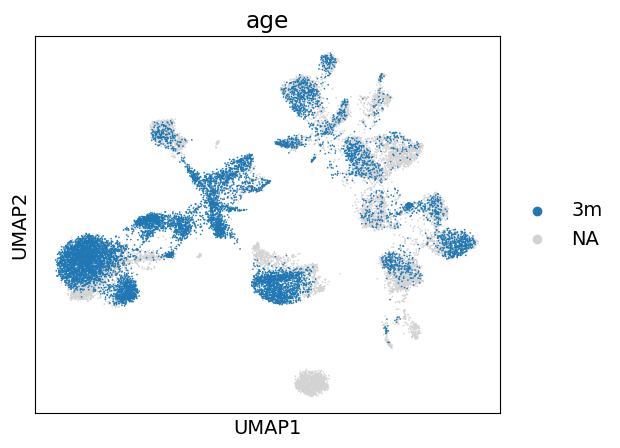

In [52]:
## highlight certain labels by specifying them with groups
sc.pl.umap(adata, color = ["age"], ax = mysize(6, 5, 100), groups = ["3m"])

### Use only certain group of cells in the UMAP ( pseudo subset )

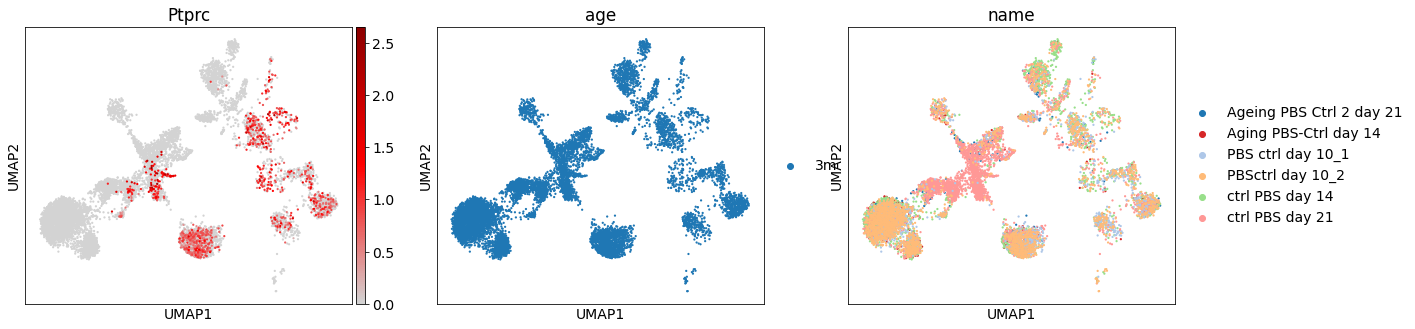

In [53]:
## Young mice only
cells = adata.obs.age == "3m"
sc.pl.umap(adata[cells], color = ["Ptprc", "age", "name"], cmap = gray_red, size = 20)

### Batch Correction
Instead of using scanpys method for k-nearest neighbour graph construction, use batch balanced version
Batch should be identifiable by a Column in the Grouping Table, and given to the method via the "batch_key" Parameter


computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain_1', the cluster labels (adata.obs, categorical) (0:00:06)


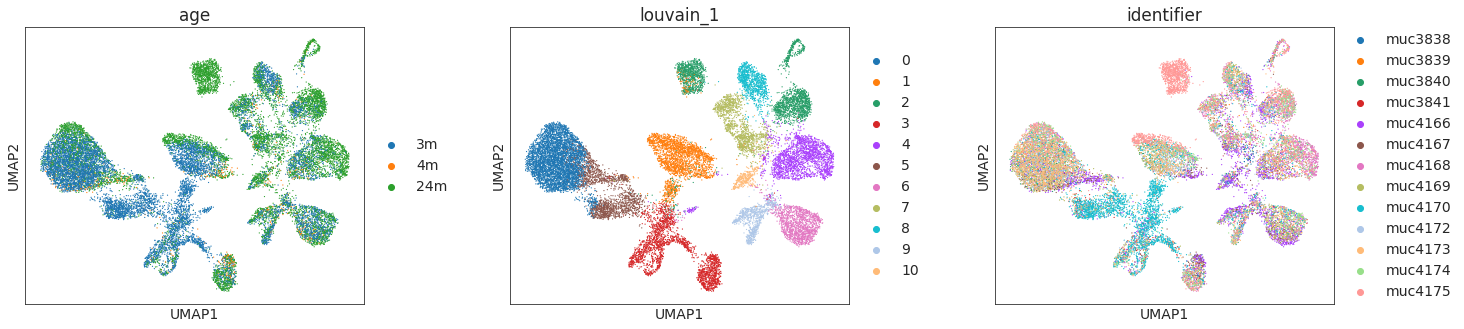

In [153]:
import bbknn

bbknn.bbknn(adata, neighbors_within_batch = 10, n_pcs = 20, batch_key = "identifier")
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution = 1, key_added = "louvain_1")
sc.tl.louvain(adata, resolution = 2, key_added = "louvain_2")
sc.tl.louvain(adata, resolution = 3, key_added = "louvain_3")

sc.pl.umap(adata, color = ["age", "louvain_1", "identifier"], wspace = 0.3)

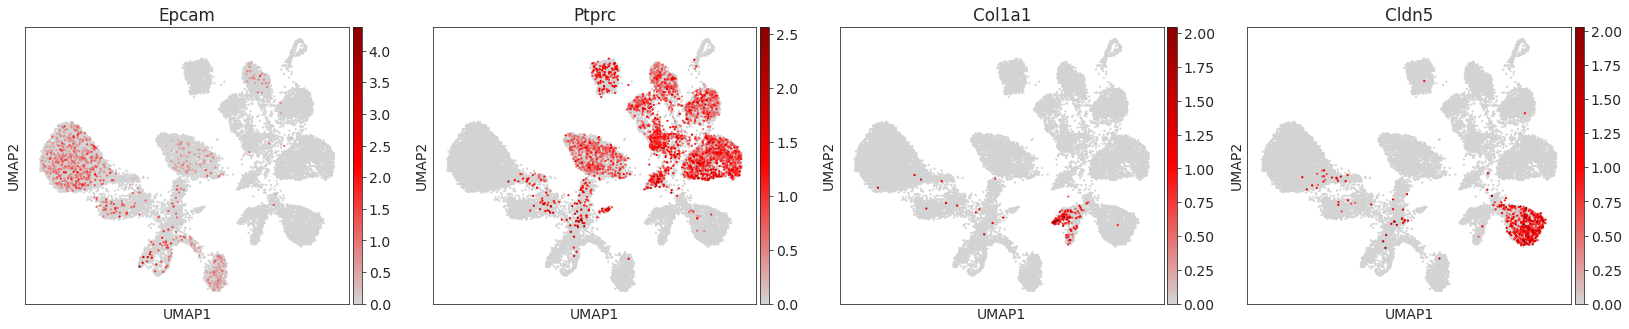

In [154]:
sc.pl.umap(adata, color = ["Epcam", "Ptprc", "Col1a1", "Cldn5"], cmap = gray_red, size = 20)

### Save adata object

In [155]:
object_folder = "/home/marvin/Data/platte_2/210921_Aging_Tutorial/"
adata.write(object_folder + "210921_Aged_Mice.h5ad")             ## 281 MB

### Diffusion Map

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99764293 0.9927415  0.9924026  0.99036354 0.989016
     0.9886253  0.98715913 0.9844573  0.9791514  0.97754276 0.9750787
     0.96943074 0.9666362  0.95643264]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)


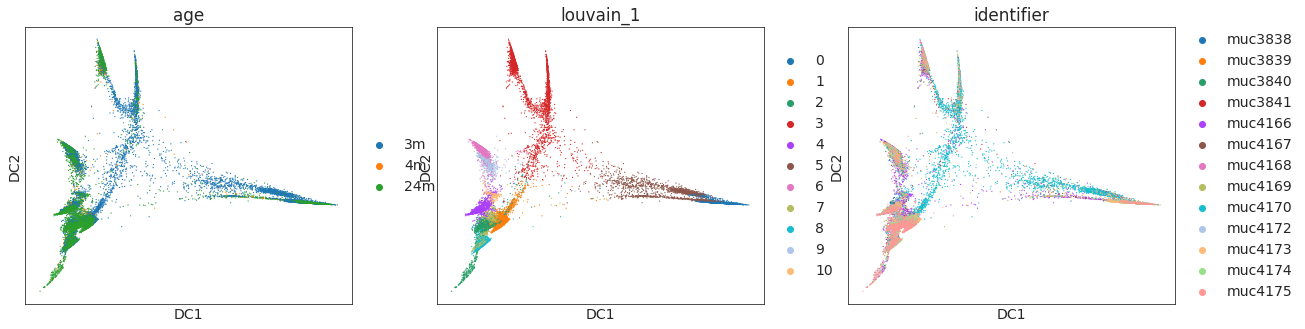

In [156]:
sc.tl.diffmap(adata)
sc.pl.diffmap(adata, color = ["age", "louvain_1", "identifier"], components = "1,2")

### Diffusion Pseudotime
Although it does not make much sense on this data set, you should have the code Snippets

In [160]:
# Choose cell with highest DC 1 value to act as root for the diffusion pseudotime and compute DPT
root_id = np.argmax(adata.obsm['X_diffmap'][:, 1])

## If you want the e.g. lowest DC2 value
## root_id = np.argmin(adata.obsm['X_diffmap'][:, 2])

adata.uns['iroot'] = np.arange(adata.n_obs)[root_id]

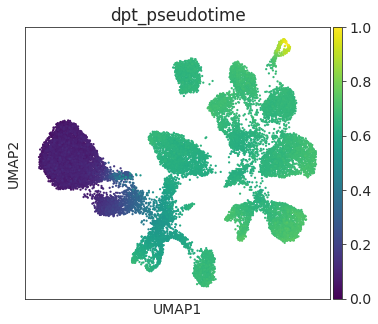

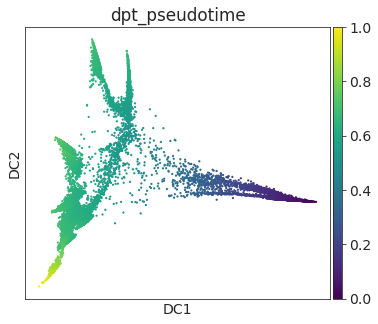

In [162]:
#Compute dpt
sc.tl.dpt(adata)
sc.pl.umap(adata, color = "dpt_pseudotime", size = 20, cmap = "viridis")
sc.pl.diffmap(adata, color = "dpt_pseudotime", size = 20, cmap = "viridis")

### PAGA Plots

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain_3', the cluster labels (adata.obs, categorical) (0:00:14)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


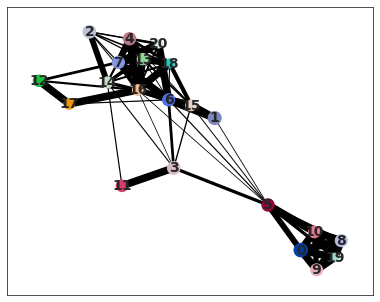

In [202]:
sc.tl.paga(adata, groups = "louvain_3")
sc.pl.paga(adata, threshold = 0.1)

--> added 'pos', the PAGA positions (adata.uns['paga'])


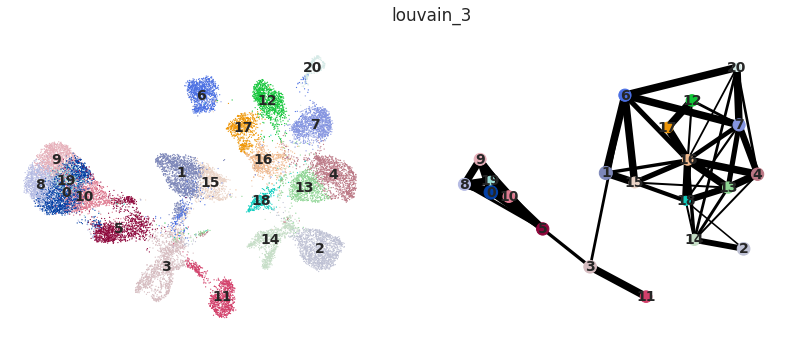

In [204]:
sc.pl.paga_compare(adata, threshold = 0.2)

--> added 'pos', the PAGA positions (adata.uns['paga'])


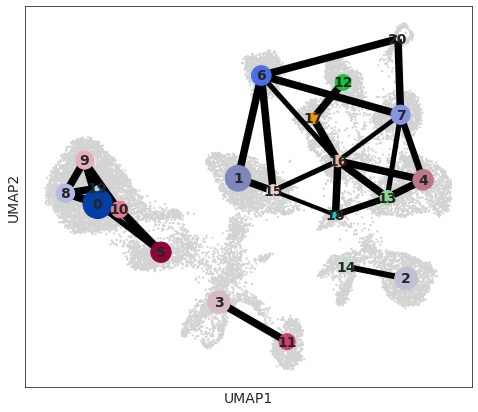

In [206]:
## Combine UMAP with PAGA (run .paga_compare first for this to work)
fig1, ax1 = plt.subplots(figsize = (8, 7))
sc.pl.umap(adata, size = 20, ax = ax1, show = False)
sc.pl.paga(adata, pos = adata.uns['paga']['pos'], show = False, node_size_power = 2, node_size_scale = 2, ax = ax1,
           threshold = 0.5)  ## add text_kwds = {'alpha':0} to remove labels
#plt.savefig(plot_folder + "umap_paga_overlay.pdf")
plt.show()

### Differential Gene Expression - All Markers Table

In [207]:
## All Markers
sc.tl.rank_genes_groups(adata, groupby = 'louvain_3', groups = "all", use_raw = False, n_genes = 500,
                        method = "wilcoxon", pts = True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)


In [195]:
print(result["pts"].shape)
result["pts"].loc[result["names"][cluster]].shape

(18019, 13)


(500, 13)

In [208]:
## Combine into one Data Frame (comparable to Marker Table)
result = adata.uns['rank_genes_groups']
allMarkers = []
for cluster in result['names'].dtype.names:
    current = pd.DataFrame({"gene": result["names"][cluster], "score": result["scores"][cluster],
                            "logfoldchange": result["logfoldchanges"][cluster], "pval": result["pvals"][cluster],
                            "pval_adj": result["pvals_adj"][cluster], 
                            "pct_within": result["pts"].loc[result["names"][cluster]][cluster],
                            "pct_outside": result["pts_rest"].loc[result["names"][cluster]][cluster],
                            "cluster": cluster})
    allMarkers.append(current)
allMarkers = pd.concat(allMarkers)
allMarkers.head()

gene      score  logfoldchange  pval  pval_adj  pct_within  \
Sftpa1  Sftpa1  59.557339       4.959664   0.0       0.0    0.999424   
Sftpc    Sftpc  58.733974       6.564003   0.0       0.0    1.000000   
Lyz2      Lyz2  58.422409       4.131709   0.0       0.0    1.000000   
Sftpb    Sftpb  55.578579       4.204879   0.0       0.0    0.998848   
Sftpd    Sftpd  54.361481       3.686075   0.0       0.0    0.958525   

        pct_outside cluster  
Sftpa1     0.268784       0  
Sftpc      0.257657       0  
Lyz2       0.462972       0  
Sftpb      0.254902       0  
Sftpd      0.226165       0

In [209]:
allMarkers.shape

(10500, 8)

In [210]:
## Write to file
allMarkers.to_csv(out_folder + "AllMarkers_louvain3.txt", sep = "\t", index = False)

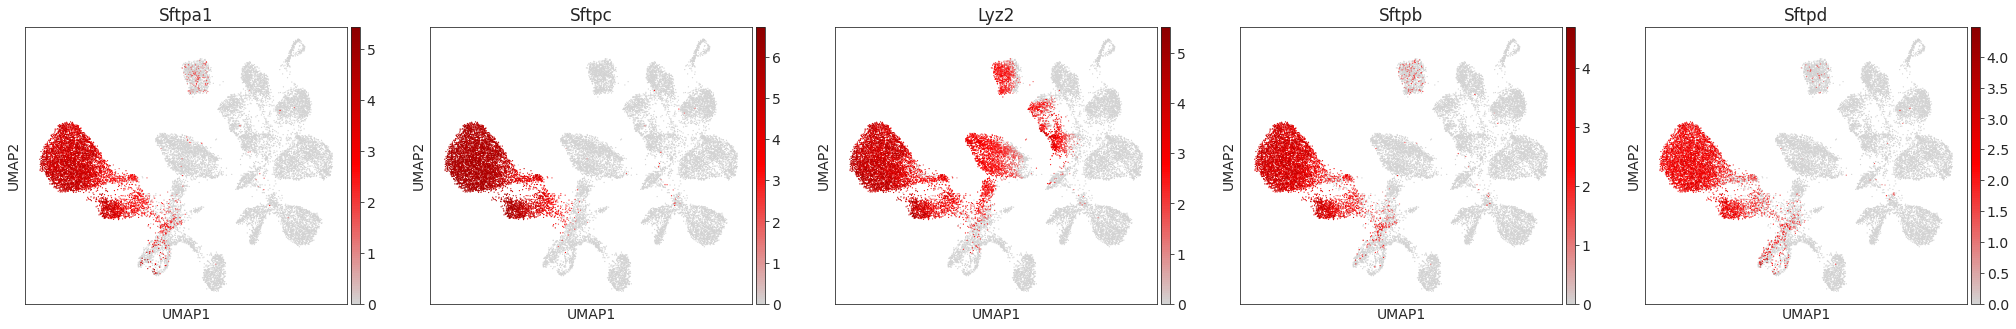

In [211]:
## Find top Genes for a Cluster
cluster = "0"
genes = allMarkers.loc[allMarkers["cluster"] == cluster, "gene"].values

sc.pl.umap(adata, color = genes[0:5], ncols = 5, color_map = gray_red)

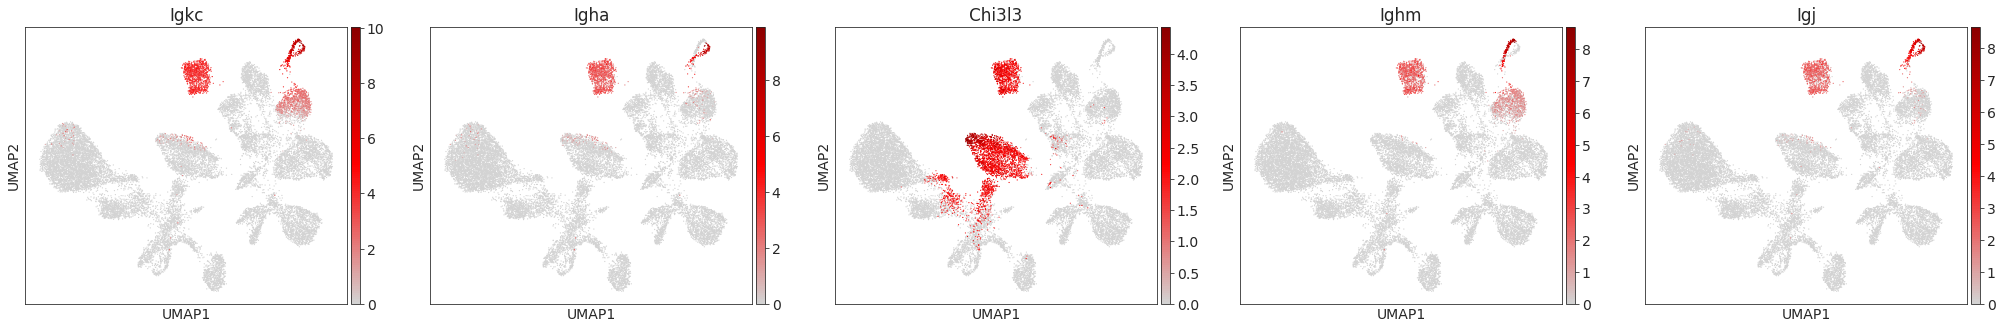

In [212]:
cluster = "6"
genes = allMarkers.loc[allMarkers["cluster"] == cluster, "gene"].values

sc.pl.umap(adata, color = genes[0:5], ncols = 5, color_map = gray_red)

### Marker Overview Plots
https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain_3']`


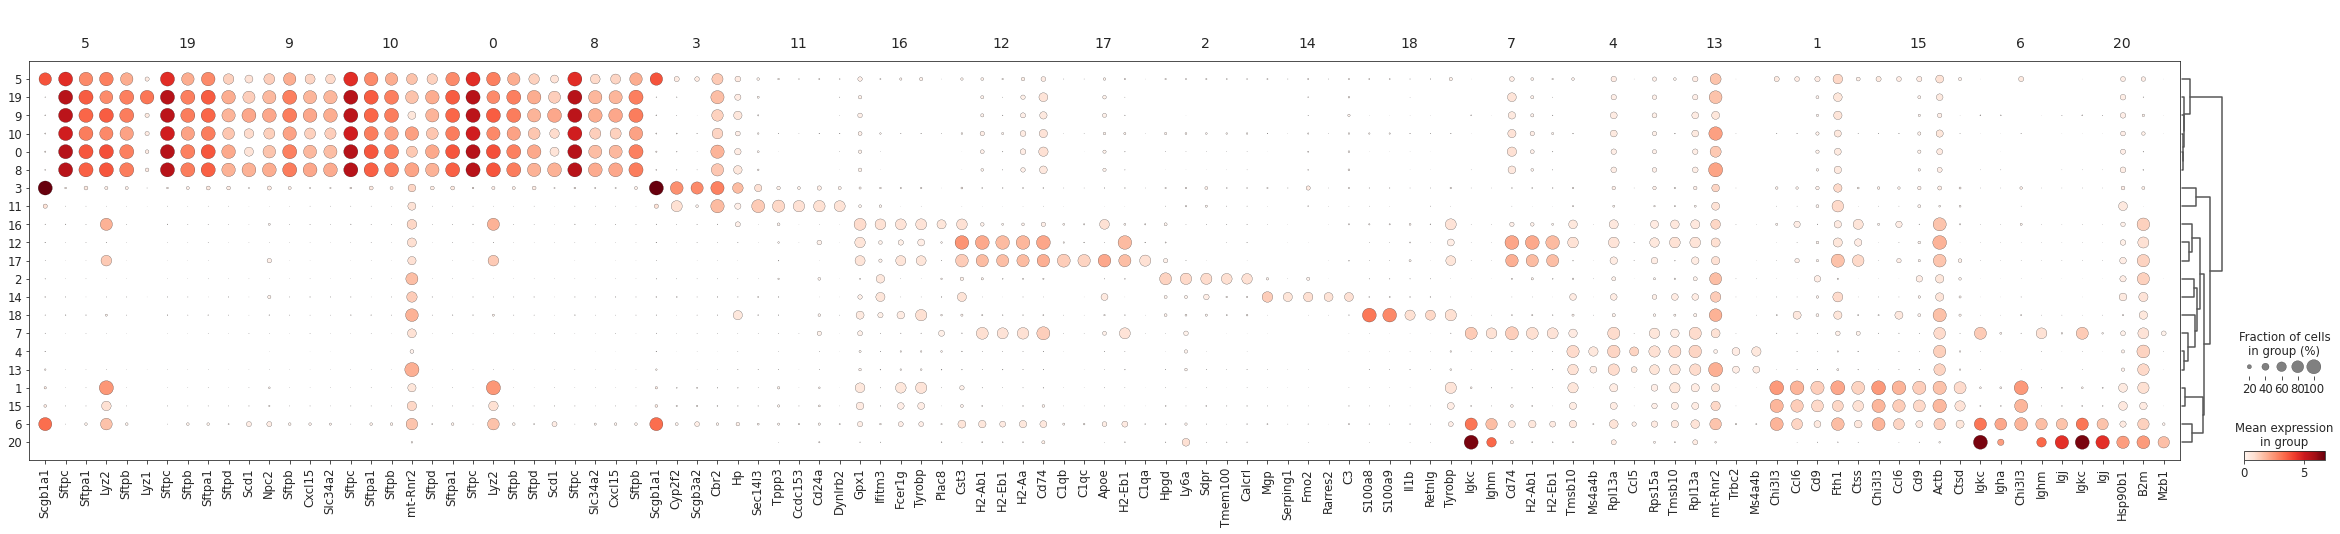

In [213]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes = 5)

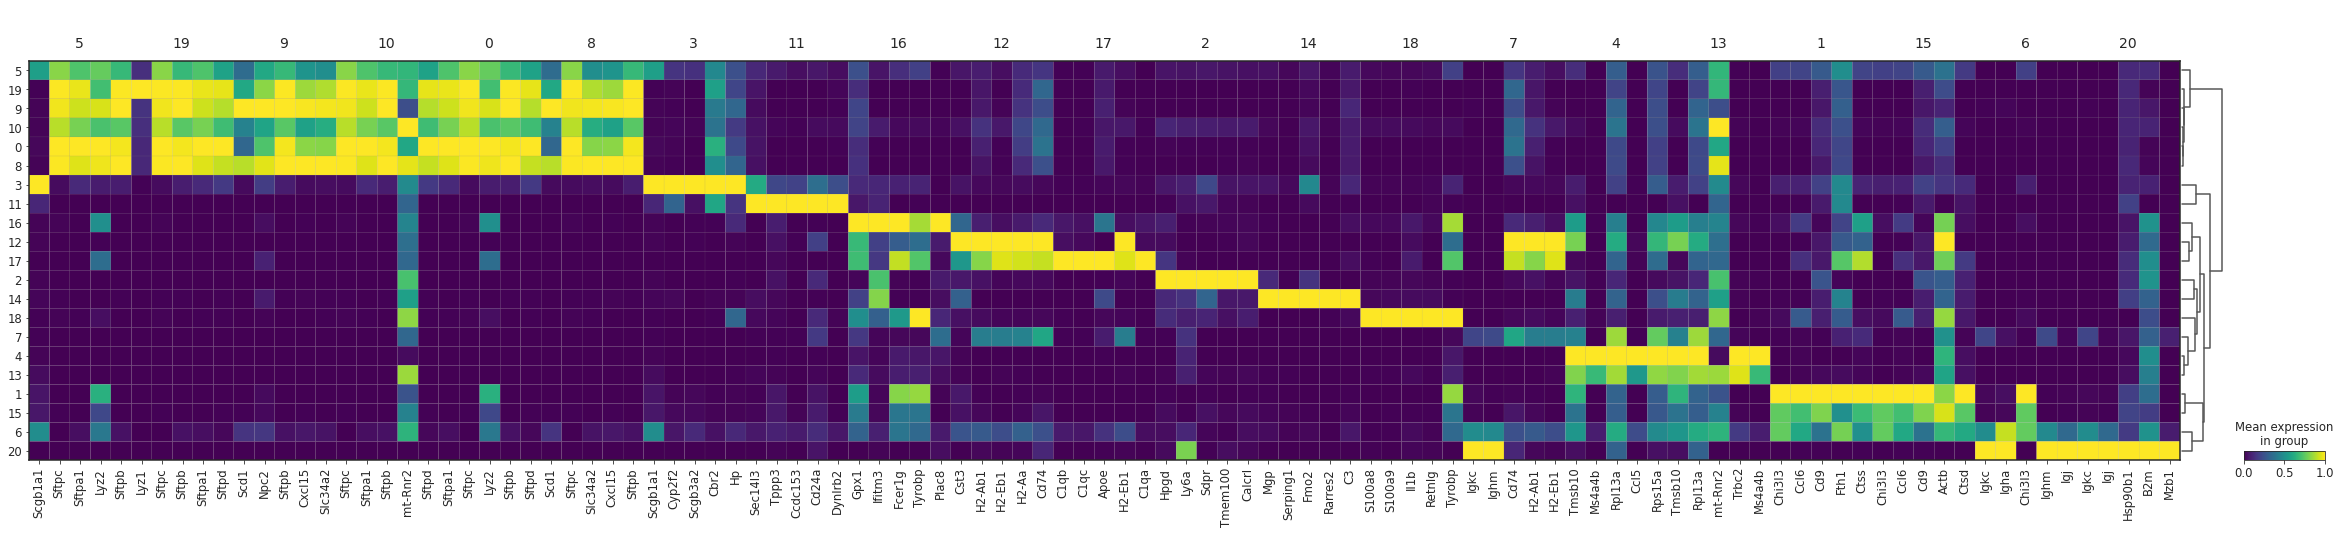

In [214]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes = 5, standard_scale = "var")

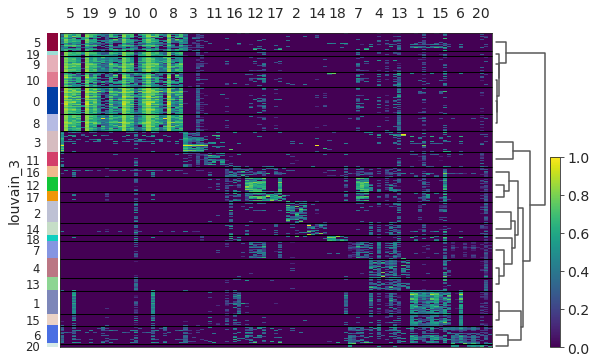

In [215]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes = 5, standard_scale = "var", cmap = "viridis")

### Highlight certain cells

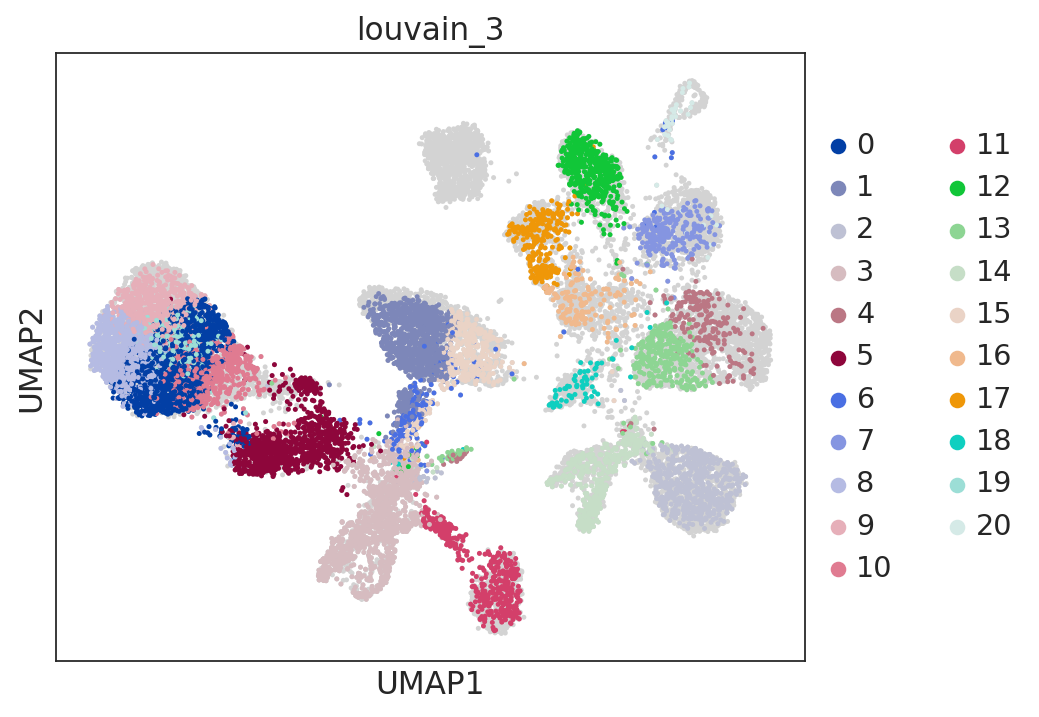

In [223]:
fig, axs = plt.subplots(figsize = (6, 5))
sc.pl.umap(adata, show = False, ax = axs, size = 20)
sc.pl.umap(adata[adata.obs.age.isin(["3m", "4m"])], color = "louvain_3", show = False, ax = axs, size = 20)
plt.show()

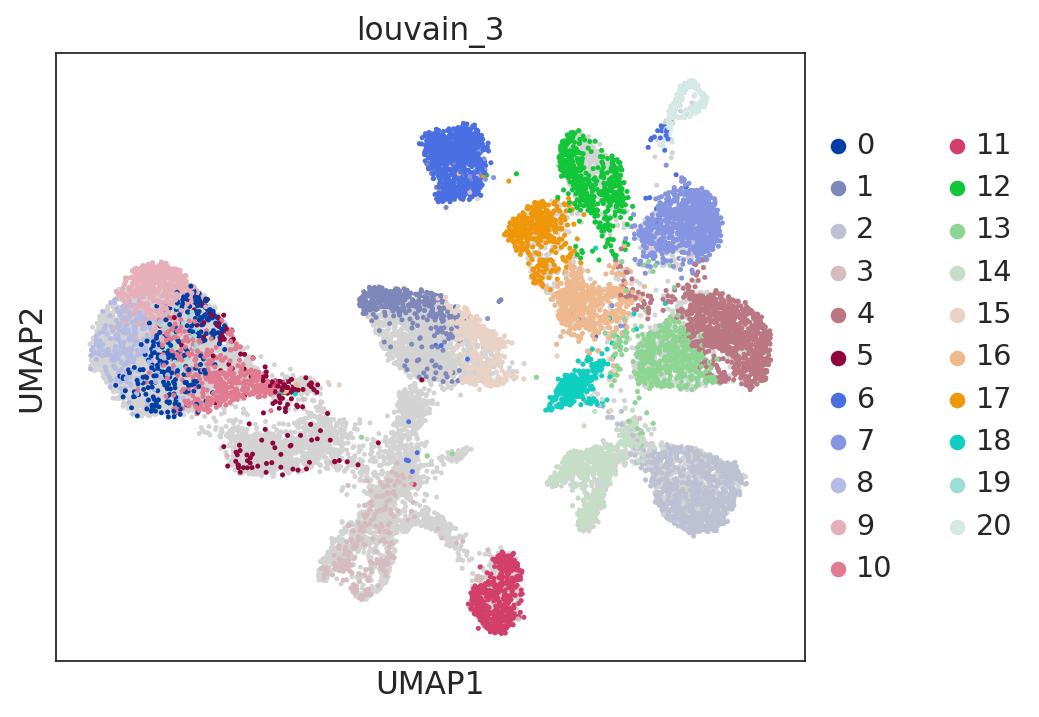

In [222]:
fig, axs = plt.subplots(figsize = (6, 5))
sc.pl.umap(adata, show = False, ax = axs, size = 20)
sc.pl.umap(adata[adata.obs.age.isin(["24m"])], color = "louvain_3", show = False, ax = axs, size = 20)
plt.show()

### Save plots by specifying folder and filename

In [216]:
## Set global plotting parameters
plot_folder = "/home/marvin/Data/platte_2/210921_Aging_Tutorial/Plots/"
sc.settings.figdir = plot_folder              ## make sure this folder exists if you want to save plot

sc.set_figure_params(vector_friendly = True)  ## for higher quality of plots
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams.update({'font.size': 14})
plt.rcParams['pdf.fonttype'] = 42
sb.set_style("ticks")

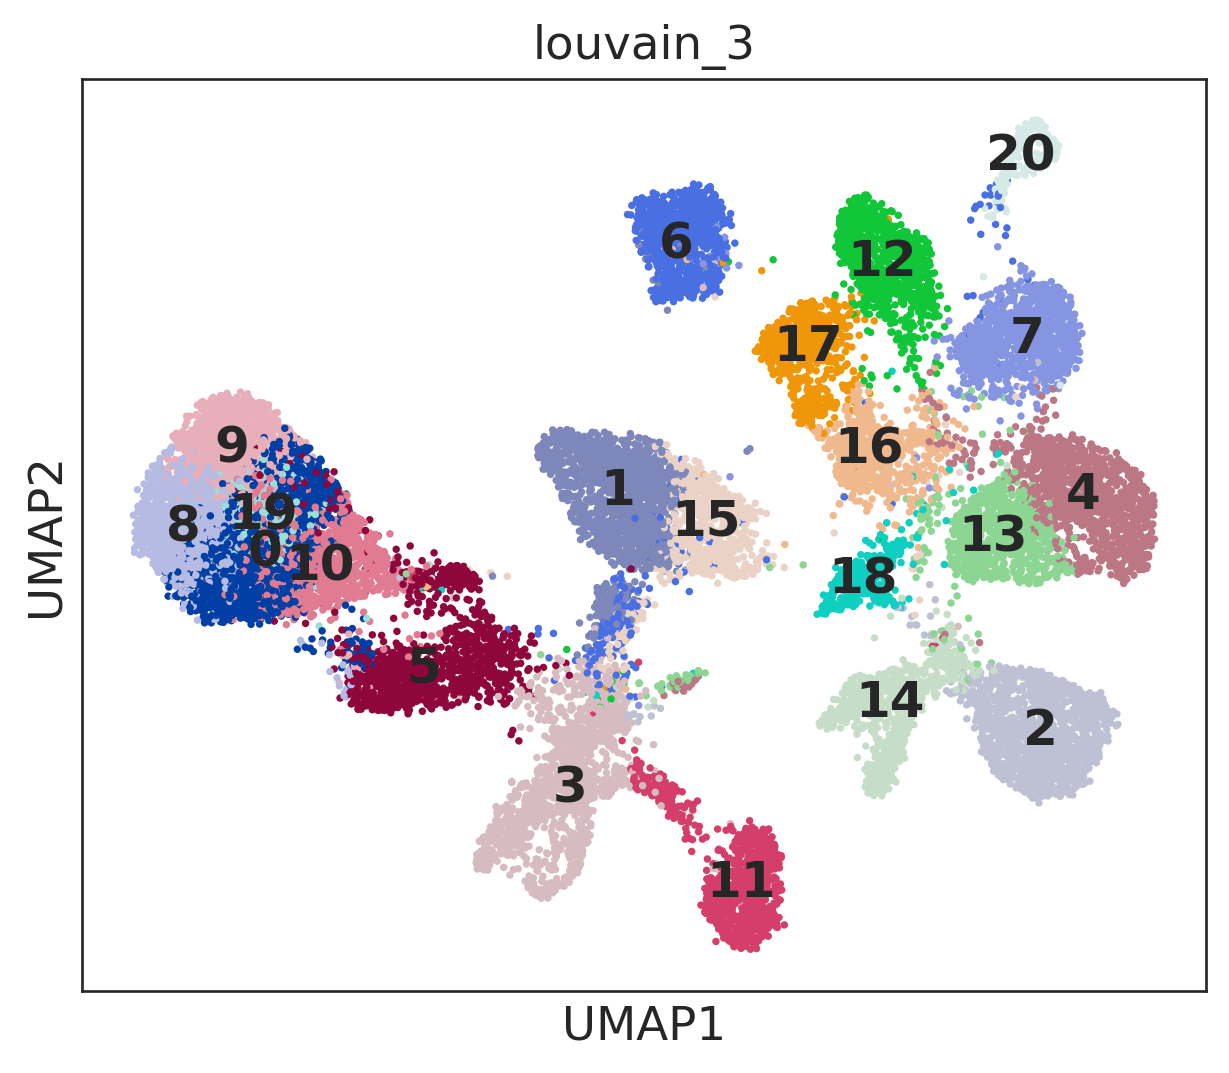

In [218]:
sc.pl.umap(adata, color = "louvain_3", ax = mysize(6, 5, 120), save = "_louvain3.pdf",
           legend_loc = "on data", size = 20, legend_fontsize = 15)

In [219]:
## Resave new louvain cluster
object_folder = "/home/marvin/Data/platte_2/210921_Aging_Tutorial/"
adata.write(object_folder + "210921_Aged_Mice.h5ad")